In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import expit, logit
import numpy as np
from tqdm import tqdm
import numpyro
import numpyro.distributions as dist
import src.Aux_functions as aux
from itertools import combinations
import matplotlib.pyplot as plt 
import time 
import blackjax 
from typing import NamedTuple, Any

print("JAX version: {}".format(jax.__version__))
print("blackjax version: {}".format(blackjax.__version__))
print("NumPyro version: {}".format(numpyro.__version__))



JAX version: 0.4.28
blackjax version: 1.2.0
NumPyro version: 0.15.2


In [2]:
key = random.PRNGKey(0)
key = random.split(key, 1)[0]

RANDOM_SEED = 7
rng = np.random.default_rng(RANDOM_SEED)

# Generate some data
n = 500
triu_dim = n*(n-1)//2

# x = random.normal(key, shape=(n,))*3
x = jnp.array(rng.normal(loc=0, scale=1, size=n), dtype=jnp.float32)
# x = jnp.array(rng.normal(loc=0, scale=3, size=n), dtype=jnp.float32)
# x2 = random.binomial(key, n=1, p=0.1, shape=(n,))
x2 = jnp.array(rng.binomial(n=1, p=.1, size=n), dtype=jnp.float32)
idx_pairs = list(combinations(range(len(x)), 2))
x_diff = jnp.array([abs(x[i] - x[j]) for i, j in idx_pairs])
x2_or = jnp.array([1 if (x2[i] + x2[j] == 1) else 0 for i, j in idx_pairs])


print(x.shape, x2.shape, x_diff.shape, x2_or.shape)

# U = jnp.array(rng.normal(loc=0, scale=1, size=(n, 2)))

# def latent_to_norm_of_diff(U):
#     idx = jnp.triu_indices(n=U.shape[0], k=1)
#     U_diff = U[idx[0]] - U[idx[1]]
#     # print(U_diff.shape)
#     return jnp.linalg.norm(U_diff, axis=1)

# U_norm = latent_to_norm_of_diff(U)
# print(U_norm.shape)

# Network data

df_edges = jnp.transpose(jnp.stack([jnp.ones(triu_dim), x_diff, x2_or]))
theta = jnp.array([-2.5, -0.25, 1])
# theta = jnp.array([-2.5, -0.5, 2])
# theta = jnp.array([-2.5, -0.5, 1.5])
# gamma = jnp.array([1.1, 0.2, -1, 1])
gamma = jnp.array([logit(0.7), logit(0.2), 0.1, -0.5])
# gamma = jnp.array([logit(.85), logit(.15)])

# triu_star_probs = expit(jnp.dot(df_edges, theta) - U_norm)
triu_star_probs = expit(jnp.dot(df_edges, theta))
# triu_star = random.binomial(key, n=1, p=triu_star_probs, shape=(triu_dim,))
triu_star = jnp.array(rng.binomial(n=1, p=triu_star_probs, size=triu_dim), dtype=jnp.float32)

triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * jnp.dot(df_edges, gamma[1:]))
# triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:])))
# triu_obs_probs = expit(triu_star*gamma[0] + (1 - triu_star)*gamma[1])
# triu_obs = random.binomial(key, n=1, p=triu_obs_probs, shape=(triu_dim,))
triu_obs = jnp.array(rng.binomial(n=1, p=triu_obs_probs, size=triu_dim), dtype = jnp.float32)

print(triu_star.shape, triu_obs.shape)

# Outcome data

@jax.jit
def degree_centrality(adj_matrix):
    """
    Compute normalized degree centrality for all nodes in the network using JAX.
    
    Parameters:
    adj_matrix (jnp.ndarray): Square adjacency matrix (n x n)
    
    Returns:
    jnp.ndarray: Vector of normalized degree centralities
    """
    # Compute degrees (sum of rows for undirected graph)
    degrees = jnp.sum(adj_matrix, axis=1)
    
    # Normalize by maximum possible degree (n-1)
    n = adj_matrix.shape[0]
    return degrees / (n - 1)
    
@jax.jit
def compute_exposures(triu_star, Z):
    mat_star = aux.Triu_to_mat(triu_star)
    # eigen_cen = aux.eigen_centrality(mat_star)
    deg_cen = degree_centrality(mat_star)
    return aux.zeigen_value(Z, deg_cen, mat_star)

mat_star = aux.Triu_to_mat(triu_star)
# Z = random.binomial(key, n=1, p=0.5, shape=(n,))
Z = jnp.array(rng.binomial(n=1, p=0.5, size=n), dtype=jnp.float32)
# exposures = jnp.dot(mat_star, Z)
exposures = compute_exposures(triu_star, Z)

# eta = jnp.array([-1, 3, -0.25, 1, 3])
eta = jnp.array([-1, 3, -0.25, 3])
# df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, x2, exposures]))
df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, exposures]))

mean_y = jnp.dot(df_nodes, eta)
sig_y = 1

# Y = random.normal(key, shape=(n,))*sig_y + mean_y
Y =  jnp.array(mean_y + rng.normal(loc=0, scale=sig_y, size=n), dtype=jnp.float32)

print(Y.shape)



(500,) (500,) (124750,) (124750,)
(124750,) (124750,)
(500,)


mean exposure:  1.5582967 
 std exposure:  0.5065012 
 median exposure:  1.481964


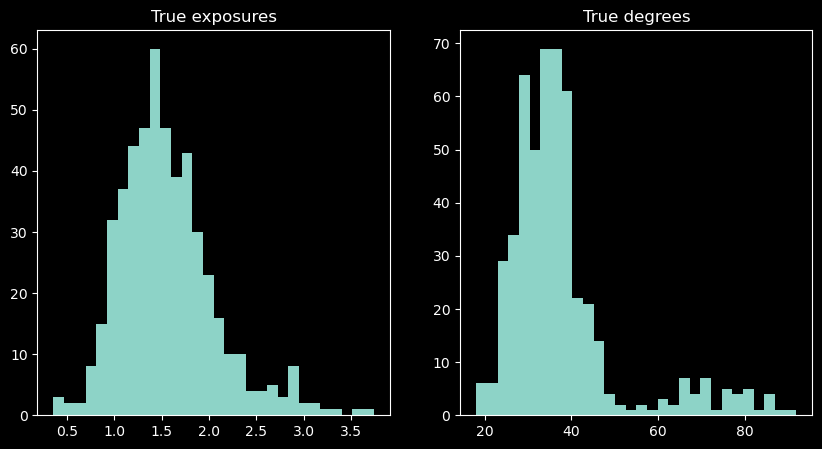

In [3]:
# panel of two plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot 1
axs[0].hist(exposures, bins=30)
axs[0].set_title("True exposures")

# plot 2
axs[1].hist(jnp.sum(mat_star, axis=1), bins=30)
axs[1].set_title("True degrees")

print("mean exposure: ", jnp.mean(exposures), "\n",
      "std exposure: ", jnp.std(exposures), "\n",
      "median exposure: ", jnp.median(exposures))

Text(0.5, 1.0, 'True vs Observed exposures')

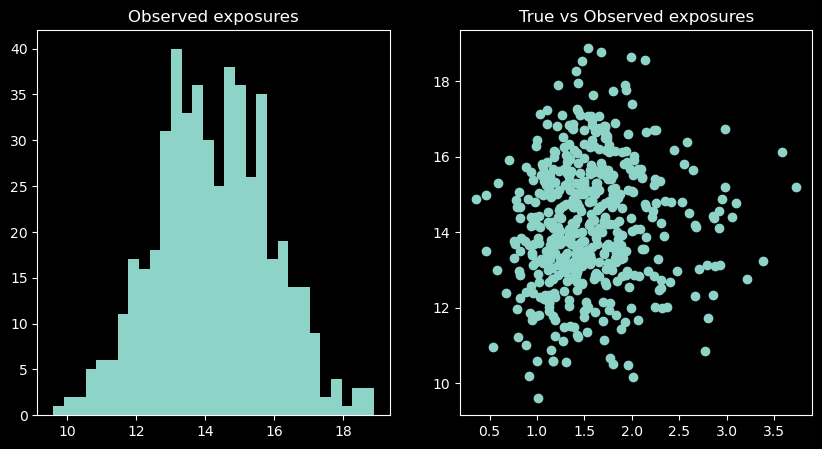

In [4]:
expos_obs = compute_exposures(triu_obs, Z)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(expos_obs, bins=30)
axs[0].set_title("Observed exposures")

axs[1].scatter(exposures, expos_obs)
axs[1].set_title("True vs Observed exposures")

# create y~x line
# x_line = np.linspace(min(exposures), max(exposures), 100)
# y_line = x_line
# plt.plot(x_line, y_line, color='red')

cor Y~exposures:  0.6483329 
 cor Y~observed exposures:  -0.025057185


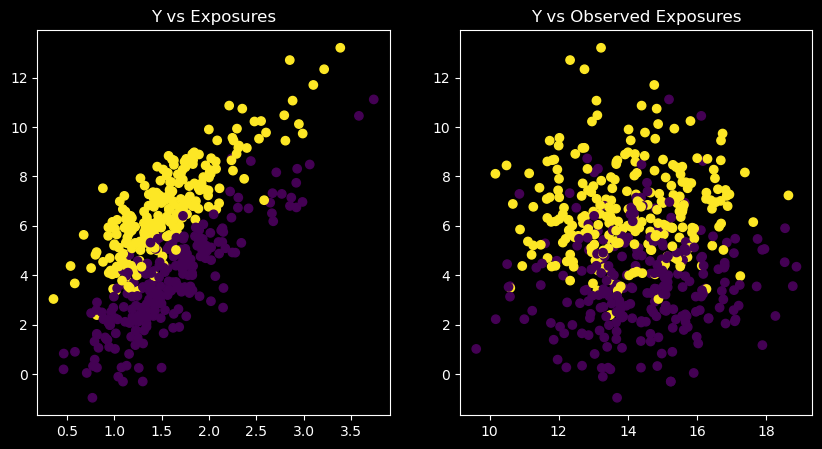

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].scatter(exposures, Y, c=Z)
axs[0].set_title("Y vs Exposures")

axs[1].scatter(expos_obs, Y, c=Z)
axs[1].set_title("Y vs Observed Exposures")

print("cor Y~exposures: ", jnp.corrcoef(Y, exposures)[0, 1], "\n",
        "cor Y~observed exposures: ", jnp.corrcoef(Y, expos_obs)[0, 1])

In [6]:
@jax.jit
def A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma):
    logits_a_star = jnp.dot(df_edges, theta)
    # a_star_log_likelihood = triu_star * (-jnp.log1p(jnp.exp(-logits_a_star))) + (1 - triu_star) * (-jnp.log1p(jnp.exp(logits_a_star)))
    a_star_log_likelihood = triu_star*logits_a_star - jnp.log1p(jnp.exp(logits_a_star))

    logits_a_obs = (triu_star * gamma[0]) + (1 - triu_star) * jnp.dot(df_edges, gamma[1:])
    # logits_a_obs = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
    # a_obs_log_likelihood = triu_obs * (-jnp.log1p(jnp.exp(-logits_a_obs))) + (1 - triu_obs) * (-jnp.log1p(jnp.exp(logits_a_obs)))
    a_obs_log_likelihood = triu_obs*logits_a_obs - jnp.log1p(jnp.exp(logits_a_obs))

    log_prob = a_star_log_likelihood + a_obs_log_likelihood 
    log_prob_sum = jnp.sum(log_prob)

    return log_prob_sum, log_prob


@jax.jit
def A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta, sigma):
    log_prob_sum_n, log_prob_n = A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma)
    # curr_a_star = aux.Triu_to_mat(triu_star)
    # exposures = jnp.dot(curr_a_star, Z)
    exposures = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, exposures]))
    mean_y = jnp.dot(df_nodes, eta)
    y_log_likelihood = - 0.5 * jnp.sum((Y - mean_y)**2) / sigma**2 - n * jnp.log(sigma)

    return log_prob_sum_n + y_log_likelihood, log_prob_n + y_log_likelihood


In [7]:
print(A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma))
print(A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta, sig_y))

(Array(-96258.05, dtype=float32), Array([-0.30260247, -0.30254233, -0.30524105, ..., -0.31642962,
       -0.34252357, -0.2952215 ], dtype=float32))
(Array(-96510.04, dtype=float32), Array([-252.29424, -252.29417, -252.29688, ..., -252.30807, -252.33417,
       -252.28687], dtype=float32))


(124750,) (124750,)
-96510.04 
 [-3.1286452 -3.2992895 -3.2163444 -3.2099972 -0.8323662 -3.3014781
 -3.2501957 -0.9402919 -3.2548623]


Text(0.5, 1.0, 'Scores')

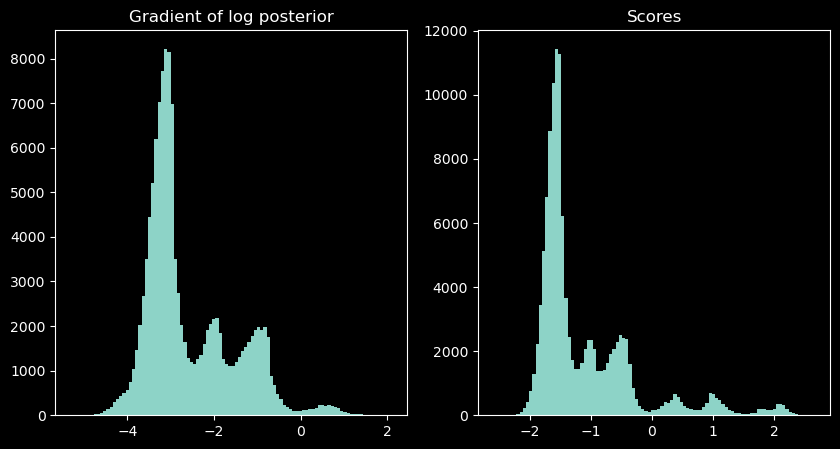

In [8]:
# val_grad_fn = jax.value_and_grad(A_star_cond_log_post, argnums=0, has_aux=True) 
val_grad_fn = jax.value_and_grad(A_star_cond_log_post_with_Y, argnums=0, has_aux=True) 

# (sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma)
(sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta, sig_y)
print(log_prob.shape, gradient.shape)
print(sum_logprob, "\n", gradient[1:10])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))


# create histogram of gradient

axs[0].hist(gradient, bins=100)
axs[0].set_title("Gradient of log posterior")

# create histogram of scores
score_grad = -(2*triu_star-1)*gradient/2
axs[1].hist(score_grad, bins=100)
axs[1].set_title("Scores")


In [9]:

def weighted_sample_and_logprobs(key, scores, M):
    # Get samples using Gumbel-max trick
    gumbel_noise = random.gumbel(key, shape=scores.shape)
    perturbed = scores + gumbel_noise
    selected_indices = jnp.argsort(-perturbed)[:M]

     # Compute log probabilities
    # log_probs = jax.nn.log_softmax(scores)
    log_probs = jax.nn.log_softmax(scores)
    # print("min log prob: ", jnp.min(log_probs), "max log prob: ", jnp.max(log_probs), "\n",
    #       "std log prob: ", jnp.std(log_probs), "mean log prob: ", jnp.mean(log_probs), "\n",
    #       "median log prob: ", jnp.median(log_probs))
    selected_log_probs = log_probs[selected_indices]
    # print("select", selected_log_probs)

    return selected_indices, selected_log_probs.sum()

@jax.jit
def propsal_logprobs(idx, scores):
    log_probs = jax.nn.log_softmax(scores)
    return log_probs[idx].sum()



In [10]:
TRIU_LEN = triu_star.shape[0]
BATCH_PROP = .0005
BATCH_LEN = int(TRIU_LEN * BATCH_PROP)
# BATCH_LEN = 500
# BATCH_LEN = 5
# BATCH_LEN = 2*jnp.ceil(jnp.log(n)).astype(int)
# BATCH_LEN = 4*jnp.ceil(jnp.log(TRIU_LEN)).astype(int)
# BATCH_LEN = jnp.ceil(jnp.log(TRIU_LEN)/2).astype(int)
print(BATCH_LEN)


#TODO: update return to 'state, info' namedtuples,
#  where state contatin the current triu_star values and info logpost and acc_rate

class IPState(NamedTuple):
    positions: Any
    logdensity: float
    logdensity_grad: float
    scores: float

class IPInfo(NamedTuple):
    acceptance_rate: float
    is_accepted: bool

@jax.jit
def GWG_kernel(rng_key, state, triu_obs, df_edges, theta, gamma,
                      Y, X, Z, eta, sig_y, step_size = 1.0):

    key1, key2 = random.split(rng_key, 2)

    # (f_baseline,_), baseline_grad = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta)
    # baseline_scores = (-(2*triu_star-1)*baseline_grad)/2

    # idx, forward_logprob = weighted_sample_and_logprobs(key1, cur_scores*jnp.exp(-alpha), BATCH_LEN)
    # idx, forward_logprob = weighted_sample_and_logprobs(key1, baseline_scores*jnp.exp(-step_size), BATCH_LEN)
    # idx, forward_logprob = weighted_sample_and_logprobs(key1, baseline_scores - step_size, BATCH_LEN)
    idx, forward_logprob = weighted_sample_and_logprobs(key1, state.scores - step_size, BATCH_LEN)

    # new_triu_star = triu_star.at[idx].set(1 - triu_star[idx])
    new_triu_star = state.positions.at[idx].set(1 - state.positions[idx])

    # backward proposal
    (f_proposed,_), backward_grad = val_grad_fn(new_triu_star, triu_obs, df_edges,
                                        theta, gamma, Y, X, Z, eta, sig_y)
    backward_scores = (-(2*new_triu_star-1)*backward_grad)/2
    # backward_logprob = propsal_logprobs(idx, backward_scores*jnp.exp(-step_size))
    backward_logprob = propsal_logprobs(idx, backward_scores - step_size)

    # get acceptance ratio (exp of log probs)
    # acceptance_ratio = jnp.clip(jnp.exp(f_proposed - f_baseline + backward_logprob - forward_logprob),
    #                             a_max=1)
    acceptance_ratio = jnp.clip(jnp.exp(f_proposed - state.logdensity + backward_logprob - forward_logprob),
                                a_max=1)
    # accept or reject
    accept = random.uniform(key2) <= acceptance_ratio

    # update triu_star
    new_triu_star = jax.lax.select(accept, new_triu_star, state.positions)
    new_logpost = jax.lax.select(accept, f_proposed, state.logdensity)
    new_grad = jax.lax.select(accept, backward_grad, state.logdensity_grad)
    new_scores = jax.lax.select(accept, backward_scores, state.scores)
    # new_triu_star = jax.lax.select(accept, new_triu_star, triu_star)
    # new_logpost = jax.lax.select(accept, f_proposed, f_baseline)
    # new_grad = jax.lax.select(accept, backward_grad, baseline_grad)
    # new_scores = jax.lax.select(accept, backward_scores, baseline_scores)

    # return new_triu_star, acceptance_ratio
    # return new_triu_star, acceptance_ratio, new_scores, new_logpost
    state = IPState(new_triu_star, new_logpost, new_grad, new_scores)
    info = IPInfo(acceptance_ratio, accept)
    # return new_triu_star, acceptance_ratio, new_logpost
    return state, info
    
     
@jax.jit
def DMALA_kernel(rng_key, triu_star, triu_obs, df_edges, theta, gamma,
                 Y, X, Z, eta, sig_y, step_size = 1.0, eps=1e-8):
    key1, key2, key3 = random.split(rng_key, 3)
    # sample idx to propose edge flip
    idx = random.choice(key1, TRIU_LEN, (BATCH_LEN,), replace=False)

    # compute baseline log-posterior and gradient
    (f_baseline,_), baseline_grad = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma,
                                                 Y, X, Z, eta, sig_y)
    baseline_scores = (-(2*triu_star-1)*baseline_grad)/2
    baseline_scores = baseline_scores[idx]
    baseline_std_scores = jnp.exp(baseline_scores - step_size)
    baseline_std_scores = jnp.clip(baseline_std_scores, -20, 20)
    
    # flip probablities
    baseline_flip_probs = baseline_std_scores / (1 + baseline_std_scores)

    # sample flip indicator I
    flip_indicator = random.uniform(key2, shape=(BATCH_LEN,)) < baseline_flip_probs
    
    # compute combined forward proposal q(\tilde{A}*_t|A*_t)
    forward_probs = baseline_flip_probs * flip_indicator + (1 - baseline_flip_probs) * (1 - flip_indicator)
    forward_proposal = jnp.sum(jnp.log(forward_probs + eps)) 

    # new proposed triu_star (after deciding which edges to flip)
    # it is proposed_triu_star with flipped edges only where flip_indicator is True
    new_triu_star = triu_star.at[idx].set(flip_indicator * (1 - triu_star[idx]) +
                                              (1 - flip_indicator) * triu_star[idx])

    # compute log-posterior and gradient for proposed triu_star
    (f_proposed,_), proposed_grad = val_grad_fn(new_triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta)
    proposed_scores = (-(2*new_triu_star-1)*proposed_grad)/2
    proposed_scores = proposed_scores[idx]
    proposed_std_scores = jnp.exp(proposed_scores - step_size)
    proposed_std_scores = jnp.clip(proposed_std_scores, -20, 20)
    backward_probs = proposed_std_scores / (1 + proposed_std_scores)

    # compute backward proposal q(A*_t|\tilde{A}*_t)
    backward_propsal = jnp.sum(jnp.log(backward_probs + eps))

    # compute acceptance ratio
    acceptance_ratio = jnp.clip(jnp.exp(f_proposed - f_baseline + backward_propsal - forward_proposal),
                                a_max=1)
    
    # accept or reject
    accept = random.uniform(key3) <= acceptance_ratio

    # update triu_star
    new_triu_star = jax.lax.select(accept, new_triu_star, triu_star)
    new_logpost = jax.lax.select(accept, f_proposed, f_baseline)
    new_grad = jax.lax.select(accept, proposed_grad, baseline_grad)
    state = IPState(new_triu_star, new_logpost, new_grad)
    info = IPInfo(acceptance_ratio, accept)
    
    return state, info
    



62


In [13]:
@jax.jit
def adaptive_step_size(alpha, acceptance_rate, target_rate=0.574, gamma=0.05):
    """
    Updates step size alpha based on the observed acceptance rate.
    """
    adjustment = gamma * (target_rate - acceptance_rate)
    return alpha + adjustment

In [11]:
# make noisy triu_star
key,_  = random.split(key)
triu_star_noisy = (triu_star * random.binomial(key, n=1, p=0.9, shape=(triu_dim,)) +
                   (1-triu_star) * random.binomial(key, n=1, p=0.1, shape=(triu_dim,)))

eta_n = eta 
eta_n = eta_n.at[3].set(eta_n[3] - 2.0)
theta_n = theta
theta_n = theta_n.at[1].set(theta_n[1] - 1.5)
# theta_n[1] = theta_n[1] - 1.5
# test A_star update

# alpha = jnp.log(2.0)
step_size = 1.0
n_iter = 1000
# n_iter = 3000
new_triu_star = triu_star_noisy
# new_triu_star = triu_obs
exposures_lst = [compute_exposures(new_triu_star, Z)]
log_post = []
acceptance_rates = []
# acceptance_rates = jnp.zeros
ADAPT_WINDOW = 100


# start = time.time()
# for i in tqdm(range(int(n_iter))):
#     key, _ = random.split(key)
  
#     new_triu_star, acc, logpost = triu_star_update(key, new_triu_star, triu_obs, df_edges,
#                                       theta, gamma, Y, x, Z, eta, step_size)
#     # new_triu_star, acc, cur_scores, cur_logpost = triu_star_update(new_triu_star,
#     #                                                                cur_scores, cur_logpost,
#     #                                                                 triu_obs, df_edges,
#     #                                   theta_n, gamma, Y, x, Z, eta_n, key, alpha=alpha)
#     exposures_lst.append(compute_exposures(new_triu_star, Z))
#     acceptance_rates.append(acc)
#     log_post.append(logpost)
    
#     if i % ADAPT_WINDOW == 0:
#         # mean_acceptance_rate = jnp.mean(jnp.array(acceptance_rates[-ADAPT_WINDOW:]))
#         mean_acceptance_rate = np.mean(acceptance_rates[-ADAPT_WINDOW:])
#         alpha = adaptive_step_size(alpha, mean_acceptance_rate)
#         print(f"Iteration {i}, New Alpha: {alpha}, Acceptance Rate: {mean_acceptance_rate}")

#         # eta_n[-1] = eta_n[-1] + 0.04
#         # eta_n = eta_n.at[3].set(eta_n[3] + 0.02)
#         # theta_n[1] = theta_n[1] + 0.03
#         # theta_n = theta_n.at[1].set(theta_n[1] + 0.015)

# print("for loop total time: ", time.time() - start)

    


In [15]:
start = time.time()

def scan_body(carry, i):
    # Unpack carry
    # key, new_triu_star, step_size, window_acceptances = carry
    key, cur_state, step_size, window_acceptances = carry
    
    # Original loop body
    key, subkey = random.split(key)
    state, info = GWG_kernel(
        subkey, cur_state, triu_obs, df_edges,
        theta, gamma, Y, x, Z, eta, sig_y, step_size
    )
    # state, info = triu_star_kernel(
    #     subkey, new_triu_star, triu_obs, df_edges,
    #     theta, gamma, Y, x, Z, eta, step_size
    # )

    
    # Handle adaptive step size
    window_acceptances = window_acceptances.at[i % ADAPT_WINDOW].set(info.acceptance_rate)
    new_step_size = jax.lax.cond(
        i % ADAPT_WINDOW == ADAPT_WINDOW - 1,
        lambda t: adaptive_step_size(t[0], jnp.mean(t[1])),
        lambda t: t[0],
        (step_size, window_acceptances)
    )
    
    # Return carry and outputs
    # new_carry = (key, new_triu_star, new_step_size, window_acceptances)
    new_carry = (key, state, new_step_size, window_acceptances)
    outputs = (state.positions, info.acceptance_rate, state.logdensity, new_step_size)
    # outputs = (new_triu_star, acc, logpost, new_step_size)
    # outputs = (exposures_s, acc, logpost, new_alpha)
    
    return new_carry, outputs

# Initialize carry values
ADAPT_WINDOW = 10
window_acceptances = jnp.zeros(ADAPT_WINDOW)

# get init state
triu_star_noisy = triu_obs
(f_init,_), grad_init = val_grad_fn(triu_star_noisy, triu_obs, df_edges,
                                    theta, gamma, Y, x, Z, eta, sig_y)
init_scores = (-(2*triu_star_noisy-1)*grad_init)/2
init_state = IPState(triu_star_noisy, f_init, grad_init, init_scores)

init_carry = (key, init_state, 1.0, window_acceptances)
# init_carry = (key, triu_star_noisy, 1.0, window_acceptances)

# Run scan
final_carry, (new_triu_star, acceptance_rates_sc, log_post_sc, alphas_sc) = jax.lax.scan(
    scan_body,
    init_carry,
    # jnp.arange(n_iter)
    jnp.arange(1500)
)


print("scan total time: ", time.time() - start)
# 

scan total time:  83.17558073997498


In [14]:
# DMALA kernel 

start = time.time()

def scan_body_dmala(carry, i):
    # Unpack carry
    key, new_triu_star, step_size, window_acceptances = carry
    
    # Original loop body
    key, subkey = random.split(key)
    state, info = DMALA_kernel(
        subkey, new_triu_star, triu_obs, df_edges,
        theta, gamma, Y, x, Z, eta, step_size
    )
    
    # Handle adaptive step size
    window_acceptances = window_acceptances.at[i % ADAPT_WINDOW].set(info.acceptance_rate)
    new_step_size = jax.lax.cond(
        i % ADAPT_WINDOW == ADAPT_WINDOW - 1,
        lambda t: adaptive_step_size(t[0], jnp.mean(t[1])),
        lambda t: t[0],
        (step_size, window_acceptances)
    )
    
    # Return carry and outputs
    # new_carry = (key, new_triu_star, new_step_size, window_acceptances)
    new_carry = (key, state.positions, new_step_size, window_acceptances)
    outputs = (state.positions, info.acceptance_rate, state.logdensity, new_step_size)
    # outputs = (new_triu_star, acc, logpost, new_step_size)
    # outputs = (exposures_s, acc, logpost, new_alpha)
    
    return new_carry, outputs

# Initialize carry values
ADAPT_WINDOW = 10
window_acceptances = jnp.zeros(ADAPT_WINDOW)
init_carry = (key, triu_star_noisy, 1.0, window_acceptances)

# Run scan
final_carry_dmala, (new_triu_star_dm, acceptance_rates_dm, log_post_dm, alphas_dm) = jax.lax.scan(
    scan_body_dmala,
    init_carry,
    # jnp.arange(n_iter)
    jnp.arange(1500)
)


print("scan DMALA total time: ", time.time() - start)
# 

TypeError: A_star_cond_log_post_with_Y() missing 1 required positional argument: 'sigma'

In [16]:
print("logpost shape", log_post_sc.shape, "\n",
      # "exposures shape", exposures_sc.shape, "\n",
      "post triu_star shape", new_triu_star.shape, "\n",
      "acceptance rates shape", acceptance_rates_sc.shape, "\n",
      "alpha shape", alphas_sc.shape, "\n",
      "new_triu_star shape", final_carry[1].positions.shape)
 
# print("logpost shape", log_post_dm.shape, "\n",
#       # "exposures shape", exposures_sc.shape, "\n",
#       "post triu_star shape", new_triu_star_dm.shape, "\n",
#       "acceptance rates shape", acceptance_rates_dm.shape, "\n",
#       "alpha shape", alphas_dm.shape, "\n",
#       "new_triu_star shape", final_carry_dmala[1].shape)

logpost shape (1500,) 
 post triu_star shape (1500, 124750) 
 acceptance rates shape (1500,) 
 alpha shape (1500,) 
 new_triu_star shape (124750,)


In [17]:
vmap_compute_exposures = jax.vmap(compute_exposures, in_axes=(0, None))
exposures_sc = vmap_compute_exposures(new_triu_star, Z)
# exposures_dmala = vmap_compute_exposures(new_triu_star_dm, Z)
print(exposures_sc.shape)
# print(exposures_sc.shape, exposures_dmala.shape)

(1500, 500)


mean acc rate :  0.85616225


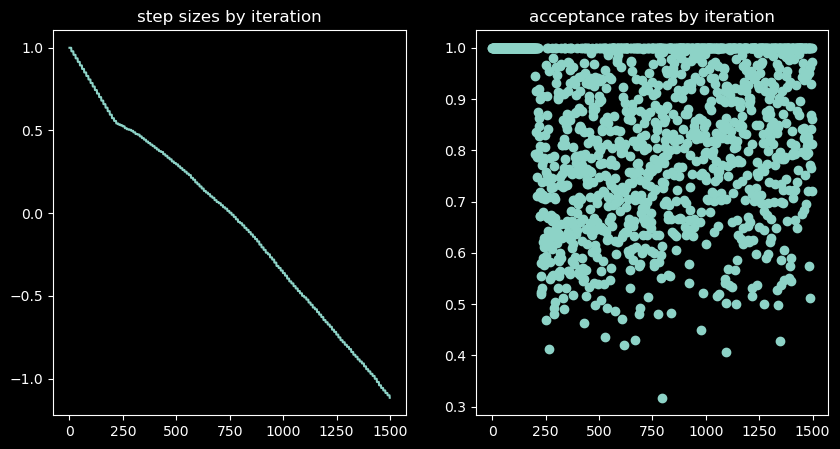

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(alphas_sc)
axs[0].set_title("step sizes by iteration")

axs[1].scatter(jnp.arange(1500),acceptance_rates_sc)
axs[1].set_title("acceptance rates by iteration")

print("mean acc rate : ", jnp.mean(acceptance_rates_sc))

True expos mean: 1.5582967 
 Posterior expos mean: 1.5724691


Text(0.5, 1.0, '-Log-posterior over iterations')

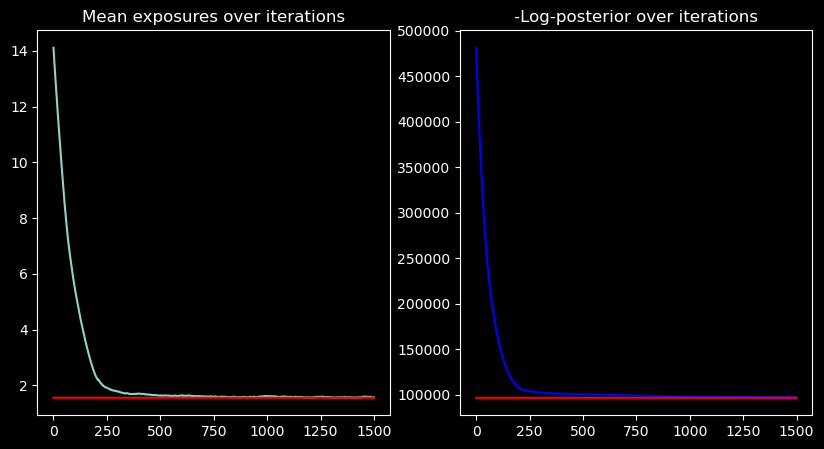

In [19]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# expos_arr = jnp.array(exposures_lst)[1:]
expos_arr = exposures_sc
print("True expos mean:", exposures.mean(), "\n",
      "Posterior expos mean:", expos_arr.mean(axis=1)[-1])

(true_logpost,_), true_grad = val_grad_fn(triu_star, triu_obs, df_edges,
                                            theta, gamma, Y, x, Z, eta, sig_y)

# create line plot of expos_arr.mean(axis=1) (y axis) vs the index (x axis)
axs[0].plot(expos_arr.mean(axis=1))
axs[0].plot(jnp.ones(expos_arr.shape[0])*exposures.mean(), color='red')
axs[0].set_title("Mean exposures over iterations")
# axs[0].xticks(range(0, 1500, 100), rotation=90)

axs[1].plot(-jnp.array(log_post_sc), color="blue")
axs[1].plot(-jnp.ones(len(log_post_sc))*true_logpost, color="red")
axs[1].set_title("-Log-posterior over iterations")
# axs[1].xticks(range(0, 1500, 100), rotation=90)


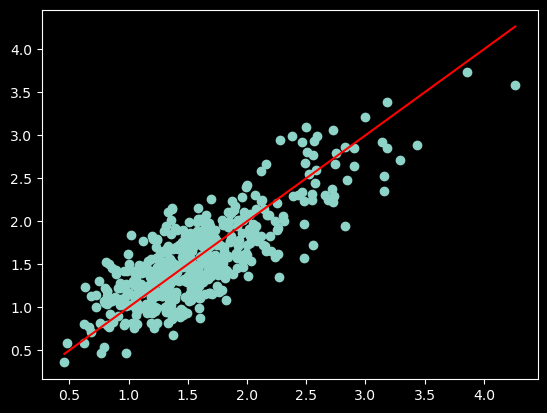

In [20]:
plt.scatter(expos_arr[-1,:], exposures)
# plt.scatter(compute_exposures(triu_obs, Z), exposures)
plt.plot([min(expos_arr[-1,:]), max(expos_arr[-1,:])], [min(expos_arr[-1,:]), max(expos_arr[-1,:])], color='red')

In [21]:
print(np.corrcoef(expos_arr[-1,:], exposures))
# print(np.corrcoef(exposures_sc[-1,:], exposures))
# print(np.corrcoef(compute_exposures(triu_star_noisy, Z), exposures))
print(np.corrcoef(compute_exposures(triu_obs, Z), exposures))

[[1.         0.80766736]
 [0.80766736 1.        ]]
[[1.         0.09572895]
 [0.09572895 1.        ]]


In [22]:
# print 2x2 table of triu_star and new_triu_star
#  for all values
def binary_contingency_table(A1, A2):
    # Table structure:
    #     A2=0  A2=1
    # A1=0  n00   n01
    # A1=1  n10   n11
    
    n00 = jnp.sum((A1 == 0) & (A2 == 0))
    n01 = jnp.sum((A1 == 0) & (A2 == 1))
    n10 = jnp.sum((A1 == 1) & (A2 == 0))
    n11 = jnp.sum((A1 == 1) & (A2 == 1))
    
    print("A1 \ A2 |  0  |  1  |")
    print("---------|-----|-----|")
    print(f"   0    | {n00:3d} | {n01:3d} |")
    print(f"   1    | {n10:3d} | {n11:3d} |")
    
    return jnp.array([[n00, n01], [n10, n11]])

# print(binary_contingency_table(triu_star, new_triu_star))
print(binary_contingency_table(triu_star, final_carry[1].positions))
print(binary_contingency_table(triu_star, triu_obs))

# print(jnp.mean(triu_star == new_triu_star))
print(jnp.mean(triu_star == final_carry[1].positions))
# print(jnp.mean(triu_star == triu_star_noisy))
print(jnp.mean(triu_star == triu_obs))


# print(jnp.sum(triu_star), jnp.sum(new_triu_star))

A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 107563 | 7773 |
   1    | 7327 | 2087 |
[[107563   7773]
 [  7327   2087]]
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 91638 | 23698 |
   1    | 2832 | 6582 |
[[91638 23698]
 [ 2832  6582]]
0.87895787
0.7873346


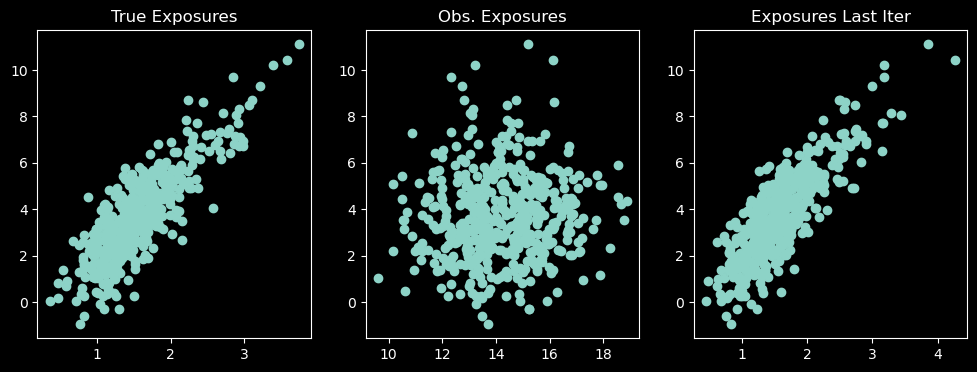

In [23]:
# plot with 3 panels of expos~Y scatter for exposures, expos_obs, expos_arr[-1,:]
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(exposures, Y-3*Z)
plt.title("True Exposures")
plt.subplot(1, 3, 2)
plt.scatter(expos_obs, Y-3*Z)
plt.title("Obs. Exposures")
plt.subplot(1, 3, 3)
plt.scatter(expos_arr[-1,:], Y-3*Z)
plt.title("Exposures Last Iter")
plt.show()


In [111]:
# Testing blackjax for continuous site (outcome model only)
import blackjax
import blackjax.mcmc.hmc as hmc
from colorama import init
import jax.scipy.stats as stats
import numpyro
import numpyro.distributions as dist
import numpyro.infer.initialization
from numpyro.infer.util import initialize_model


def outcome_model(X, Z, triu_star, Y=None):
    # Outcome model
    expos = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, expos]))

    # priors
    with numpyro.plate("eta_plate", df_nodes.shape[1]):
        eta = numpyro.sample("eta", dist.Normal(0, 5))
    
    # log_sig_y = numpyro.sample("log_sig_y", dist.Normal(0, 1))
    # sig_y = numpyro.sample("sig_y", dist.LogNormal(scale=1.0))
    sig_y = numpyro.sample("sig_y", dist.HalfNormal(2.0))
    # likelihood
    # mean_y = jnp.dot(df_nodes, eta)
    mean_y = df_nodes @ eta
    # numpyro.sample("Y", dist.Normal(mean_y, jnp.exp(log_sig_y)), obs=Y)
    numpyro.sample("Y", dist.Normal(mean_y, sig_y), obs=Y)
    
    
def networks_models(triu_star, triu_obs, df_edges):
    # Proxy nets model
    # priors
    with numpyro.plate("gamma_plate", 1 + df_edges.shape[1]):
        gamma = numpyro.sample("gamma", dist.Normal(0, 5))
    
    # likelihood
    # obs_logits = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
    obs_logits = triu_star*gamma[0] + (1 - triu_star)* (df_edges @ gamma[1:])
    # obs_logits = jnp.where(triu_star == 1, gamma[0], gamma[1])
    numpyro.sample("triu_obs", dist.Bernoulli(logits=obs_logits), obs=triu_obs)

    # True network model (given triu_star value)
    # priors
    with numpyro.plate("theta_plate", df_edges.shape[1]):
        theta = numpyro.sample("theta", dist.Normal(0, 5))

    # likelihood
    # star_logits = jnp.dot(df_edges, theta)
    star_logits = df_edges @ theta
    numpyro.sample("triu_star", dist.Bernoulli(logits=star_logits), obs=triu_star)



rng_key, init_key = random.split(key)

init_params_outcome, potential_fn_gen_outcome, *_ = initialize_model(
    init_key,
    outcome_model,
    init_strategy=numpyro.infer.initialization.init_to_value(
        values={
            "eta": jnp.zeros(4),
            "sig_y": 1.0 # due to ExpTransform it equivalence of sig=0
        }
    ),
    # model_args=(x, Z, triu_star, triu_obs, df_edges, Y),
    # model_args=(x, Z, triu_obs, triu_obs, df_edges, Y),
    # model_args=(x, Z, final_carry[1], Y),
    model_args=(x, Z, triu_star, Y),
    # model_args=(x, Z, final_carry[1], Y),
    dynamic_args=True
    )

# logdensity_fn = lambda position: -potential_fn_gen(x, Z, triu_star, Y)(position)
# logdensity_fn = lambda position: -potential_fn_gen(x, Z, triu_star, triu_obs, df_edges, Y)(position)
def logdensity_fn_outcome(vals):
    # return -potential_fn_gen_outcome(x, Z, final_carry[1], Y)(position)
    # return -potential_fn_gen_outcome(x, Z, triu_star, Y)(position)
    return -potential_fn_gen_outcome(x, Z, final_carry[1].positions, Y)(vals)
# logdensity_fn = lambda position: -potential_fn_gen(x, Z, final_carry[1], Y)(position)
initial_position_oc = init_params_outcome.z
print(initial_position_oc)

#  repeat for network model

init_params_network, potential_fn_gen_network, *_ = initialize_model(
    init_key,
    networks_models,
    # init_strategy=numpyro.infer.initialization.init_to_value(
    #     values={
    #         "gamma": jnp.zeros(1 + df_edges.shape[1]),
    #         "theta": jnp.zeros(df_edges.shape[1])
    #     }
    # ),
    model_args=(triu_star, triu_obs, df_edges),
    dynamic_args=True
    )


def logdensity_fn_network(vals):
    # return -potential_fn_gen_network(triu_star, triu_obs, df_edges)(position)
    return -potential_fn_gen_network(final_carry[1].positions, triu_obs, df_edges)(vals)

initial_position_net = init_params_network.z
print(initial_position_net)

{'eta': Array([0., 0., 0., 0.], dtype=float32), 'sig_y': Array(0., dtype=float32, weak_type=True)}
{'gamma': Array([-0.6888647 ,  0.08883381, -1.0095253 , -0.9617739 ], dtype=float32), 'theta': Array([ 0.4629445,  1.3932247, -1.3859057], dtype=float32)}


In [25]:
final_carry[1].positions.shape

(124750,)

In [26]:
print(logdensity_fn_outcome(initial_position_oc))

-8596.267


In [71]:
rng_key, warmup_key = random.split(rng_key)

step_size = 1e-7
# mala kernel
# mala_oc = blackjax.mala(logdensity_fn_outcome, step_size)
mala_oc = blackjax.mala.build_kernel()
# init state
# state = mala_oc.init(initial_position_oc)
state = blackjax.mala.init(initial_position_oc, logdensity_fn_outcome)
# jit compile the kernel step function
# step = jax.jit(mala_oc.step)   
# new_state, info = step(rng_key, state)
new_state, info = mala_oc(rng_key, state, logdensity_fn_outcome, step_size)
print(new_state.position["eta"], type(new_state.position["eta"]),
       "\n", new_state.position["sig_y"], type(new_state.position["sig_y"]))
print(state.position)

[-0.68879074  0.0888826  -1.0096172  -0.96116596] <class 'jaxlib.xla_extension.ArrayImpl'> 
 1.0336552 <class 'jaxlib.xla_extension.ArrayImpl'>
{'eta': Array([-0.6888647 ,  0.08883381, -1.0095253 , -0.9617739 ], dtype=float32), 'sig_y': Array(1.0336714, dtype=float32)}


In [72]:
%%time

class AdaptState(NamedTuple):
    state: Any  # MALA state
    step_size: float
    mean_acceptance: float
    iteration: int  

def adaptive_step_size_mala(cur_step_size, acc_rate, target_rate, adapt_rate):
    log_step = jnp.log(cur_step_size)
    log_step = log_step + adapt_rate * (acc_rate - target_rate)
    new_step_size = jnp.exp(log_step)
    return new_step_size

def inference_loop(
    rng_key, 
    kernel, 
    initial_state, 
    logdensity_fn, 
    initial_step_size: float,
    num_samples: int,
    adapt_window: int = 1,  # New parameter
    target_acceptance: float = 0.8,
    adaptation_rate: float = 0.1,
    num_warmpup: int = 5000,
):
    def one_step(carry, key):
        adapt_state = carry
        
        # Run MALA step
        new_state, info = kernel(
            key, 
            adapt_state.state, 
            logdensity_fn, 
            adapt_state.step_size
        )
        
        # Update step size only every adapt_every iterations
        should_adapt = ((adapt_state.iteration + 1) % adapt_window == 0) & (adapt_state.iteration <= num_warmpup)
        # log_step = jnp.log(adapt_state.step_size)
        # log_step = jnp.where(
        #     should_adapt,
        #     log_step + adaptation_rate * (info.acceptance_rate - target_acceptance),
        #     log_step
        # )
        # new_step_size = jnp.exp(log_step)
        new_step_size = jnp.where(
            should_adapt,
            adaptive_step_size_mala(adapt_state.step_size, 
                                    info.acceptance_rate,
                                    target_acceptance,
                                    adaptation_rate),
            adapt_state.step_size
        )
        
        # Update mean acceptance rate
        new_mean_acc = adapt_state.mean_acceptance + (
            info.acceptance_rate - adapt_state.mean_acceptance
        ) / (adapt_state.iteration + 1) # Running average accept rate 
        
        new_adapt_state = AdaptState(
            state=new_state,
            step_size=new_step_size,
            mean_acceptance=new_mean_acc,
            iteration=adapt_state.iteration + 1
        )
        
        return new_adapt_state, (new_state, info.acceptance_rate, new_step_size)

    keys = random.split(rng_key, num_samples)
    init_adapt_state = AdaptState(
        state=initial_state,
        step_size=initial_step_size,
        mean_acceptance=0.0,
        iteration=0
    )
    
    _, (states, acc_rates, step_sizes) = jax.lax.scan(one_step, init_adapt_state, keys)
    
    return states, acc_rates, step_sizes
# Usage:
sample_key, warmup_key = random.split(warmup_key)

states, acc_rates, step_sizes = inference_loop(
    sample_key,
    mala_oc,
    state, 
    logdensity_fn_outcome,
    initial_step_size=1e-2,
    num_samples=10000,
    target_acceptance=0.8
)

CPU times: total: 1.17 s
Wall time: 1.26 s


In [39]:
states

MALAState(position={'eta': Array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       ...,
       [-0.8734812 ,  3.0930789 , -0.24368569,  2.8853288 ],
       [-0.85944617,  3.0636783 , -0.24174832,  2.8992503 ],
       [-0.85944617,  3.0636783 , -0.24174832,  2.8992503 ]],      dtype=float32), 'sig_y': Array([0.        , 0.        , 0.        , ..., 0.02362589, 0.01829126,
       0.01829126], dtype=float32, weak_type=True)}, logdensity=Array([-8596.267  , -8596.267  , -8596.267  , ...,  -726.07336,
        -726.2707 ,  -726.2707 ], dtype=float32), logdensity_grad={'eta': Array([[ 2.5884568e+03,  1.6265765e+03, -3.6812451e+02,  4.4641528e+03],
       [ 2.5884568e+03,  1.6265765e+03, -3.6812451e+02,  4.4641528e+03],
       [ 2.5884568e+03,  1.6265765e+03, -3.6812451e+02,  4.4641528e+03],
       ...,
       [-1.0077976e+01, -4.6716661e+00, -3.0693354e+01, -6.

0.7470851 0.0005154062


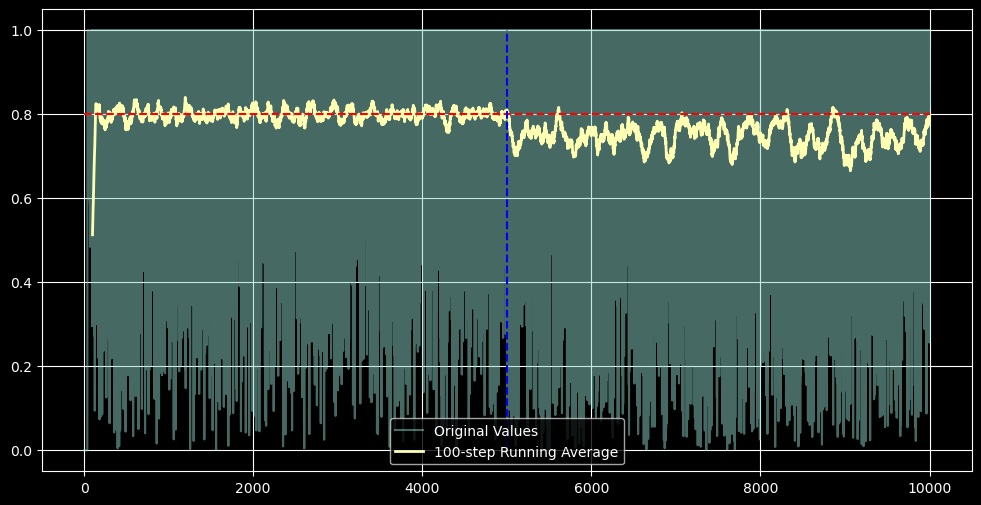

In [128]:
print(acc_rates[5000:].mean(), step_sizes[-1])
# plt.subplot(1, 2, 1)
# # plt.plot(step_sizes)
# plt.plot(step_sizes)
# plt.subplot(1, 2, 2)
# plt.plot(acc_rates)
def plot_running_average(values, window=100, hline = True, num_warmpup=5000, target_rate=0.8):
    # Calculate running average
    running_avg = np.convolve(values, np.ones(window)/window, mode='valid')
    
    # Create x-axis values
    x_orig = np.arange(len(values))
    x_avg = np.arange(window-1, len(values))
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(x_orig, values, alpha=0.5, label='Original Values')
    plt.plot(x_avg, running_avg, linewidth=2, label=f'{window}-step Running Average')
    if hline:
        plt.hlines(target_rate, 0, len(x_orig), color='red', linestyle='--')
        plt.vlines(num_warmpup, 0, 1, color='blue', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_running_average(acc_rates)

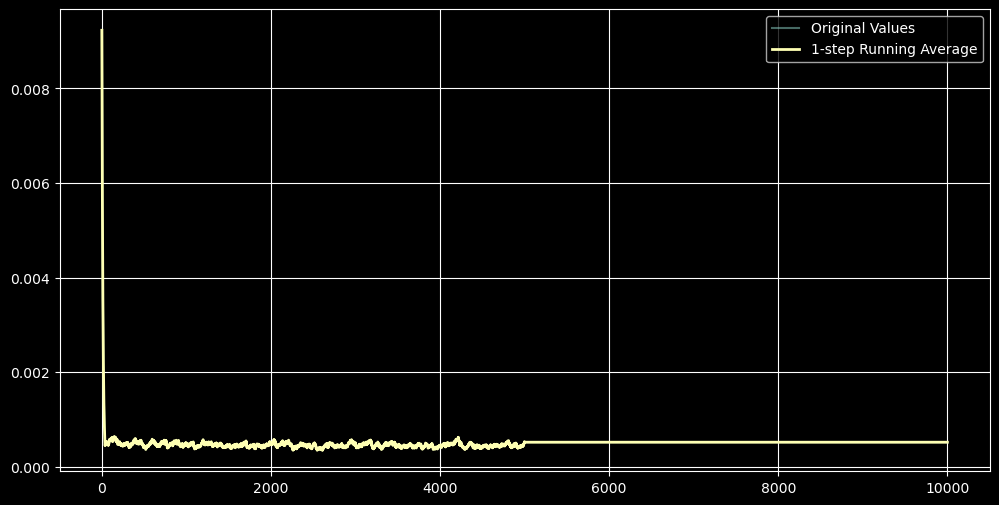

In [74]:
plot_running_average(step_sizes, hline=False, window=1)

In [75]:
# acceptance_rate = np.mean(infos)
# num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acc_rates[5000:].mean():.2f}")

print("true gamma: ", gamma, "\n",
      "true eta: ", eta, "\n",
      "true theta: ", theta)

# print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.75
true gamma:  [ 0.84729785 -1.3862944   0.1        -0.5       ] 
 true eta:  [-1.    3.   -0.25  3.  ] 
 true theta:  [-2.5  -0.25  1.  ]


In [76]:
post = {"eta" : states.position["eta"][5000:,][None, ...], 
        # "sig_y" : states.position["sig_y"][20000:,][None, ...],}
        "sig_y" : jnp.exp(states.position["sig_y"][5000:,][None, ...]),}
        # "sig_y" : jnp.exp(states.position["log_sig_y"][20000:,][None, ...]),}

print(post["eta"].shape, post["sig_y"].shape)

(1, 5000, 4) (1, 5000)


In [77]:
import arviz as az

# idata = az.from_dict(posterior={k: v[None, ...] for k, v in states.position.items()}, )
idata = az.from_dict(posterior=post)
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta[0],-1.142,0.161,-1.462,-0.863,0.028,0.020,32.0,99.0,NaN
eta[1],3.111,0.086,2.956,3.271,0.008,0.006,118.0,318.0,NaN
eta[2],-0.328,0.048,-0.418,-0.239,0.002,0.002,467.0,1008.0,NaN
eta[3],3.030,0.089,2.869,3.193,0.015,0.011,36.0,123.0,NaN
sig_y,1.011,0.032,0.955,1.073,0.001,0.001,1411.0,2298.0,NaN


array([[<Axes: title={'center': 'eta'}>, <Axes: title={'center': 'eta'}>],
       [<Axes: title={'center': 'sig_y'}>,
        <Axes: title={'center': 'sig_y'}>]], dtype=object)

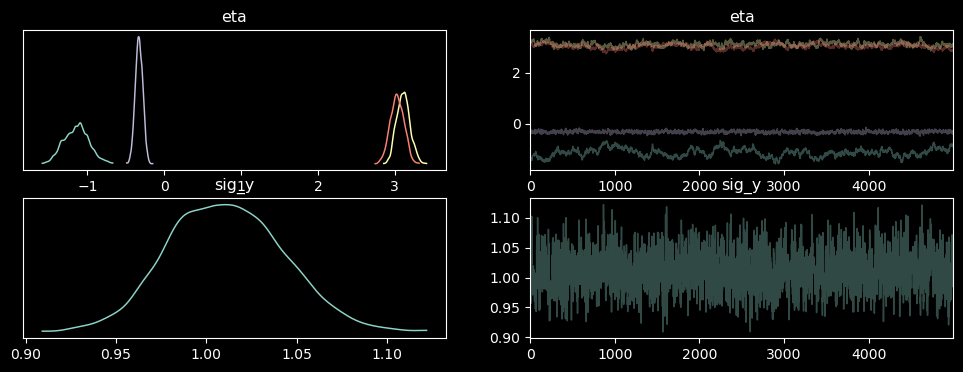

In [78]:
az.plot_trace(idata, var_names=["eta", "sig_y"])

In [79]:
# run MALA for network model

rng_key, warmup_key = random.split(rng_key)

step_size = 1e-7
# mala kernel
# mala_oc = blackjax.mala(logdensity_fn_outcome, step_size)
mala_net = blackjax.mala.build_kernel()
# init state
# state = mala_oc.init(initial_position_oc)
state = blackjax.mala.init(initial_position_net, logdensity_fn_network)
# jit compile the kernel step function
# step = jax.jit(mala_oc.step)   
# new_state, info = step(rng_key, state)
new_state, info = mala_oc(rng_key, state, logdensity_fn_network, step_size)
print(new_state.position["gamma"], type(new_state.position["gamma"]),
         "\n", new_state.position["theta"], type(new_state.position["theta"]))
print(state.position)


[-0.68829966  0.0870968  -1.0098865  -0.962228  ] <class 'jaxlib.xla_extension.ArrayImpl'> 
 [ 0.4539393  1.3821404 -1.3865485] <class 'jaxlib.xla_extension.ArrayImpl'>
{'gamma': Array([-0.6888647 ,  0.08883381, -1.0095253 , -0.9617739 ], dtype=float32), 'theta': Array([ 0.4629445,  1.3932247, -1.3859057], dtype=float32)}


In [80]:
%%time

sample_key,_ = random.split(key)
net_states, net_acc_rates, net_step_sizes = inference_loop(
    sample_key,
    mala_net,
    state, 
    logdensity_fn_network,
    initial_step_size=1e-2,
    num_samples=10000,
    target_acceptance=0.8
)

CPU times: total: 29.4 s
Wall time: 26.3 s


0.77623224 1.9752799e-05


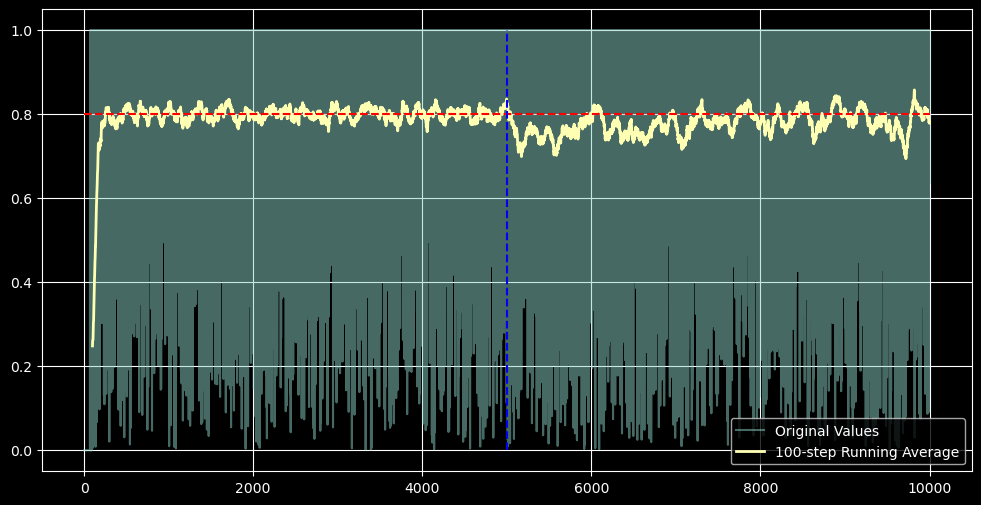

In [81]:
print(net_acc_rates[5000:].mean(), net_step_sizes[-1])
plot_running_average(net_acc_rates)

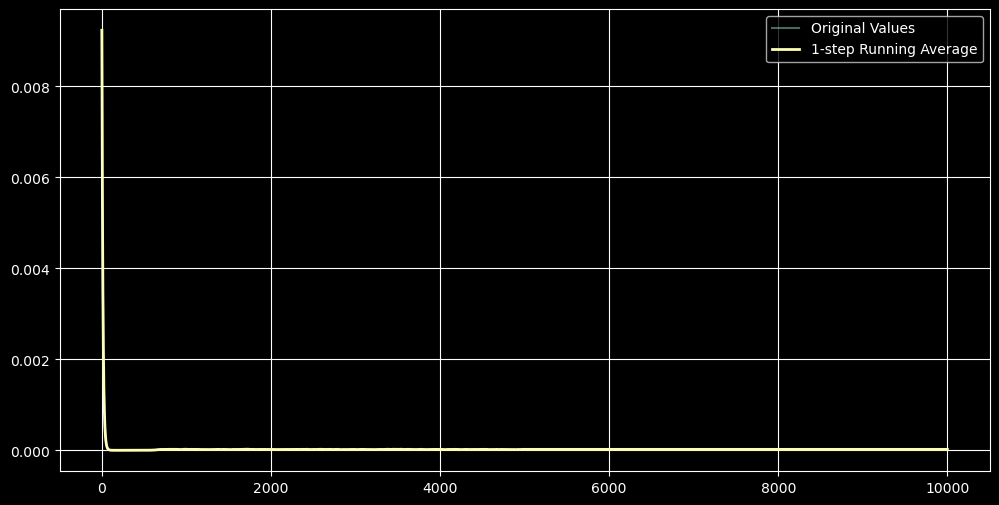

In [128]:
plot_running_average(net_step_sizes, hline=False, window=1)

In [82]:
print("true gamma: ", gamma, "\n",
      "true eta: ", eta, "\n",
      "true theta: ", theta)

net_post = {"gamma" : net_states.position["gamma"][5000:,][None, ...],
            "theta" : net_states.position["theta"][5000:,][None, ...],}



true gamma:  [ 0.84729785 -1.3862944   0.1        -0.5       ] 
 true eta:  [-1.    3.   -0.25  3.  ] 
 true theta:  [-2.5  -0.25  1.  ]


In [83]:
idata_net = az.from_dict(posterior=net_post)
az.summary(idata_net)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma[0],0.933,0.022,0.891,0.974,0.002,0.002,103.0,181.0,NaN
gamma[1],-1.425,0.013,-1.449,-1.402,0.001,0.001,153.0,498.0,NaN
gamma[2],0.109,0.009,0.091,0.124,0.001,0.000,256.0,652.0,NaN
gamma[3],-0.462,0.022,-0.504,-0.420,0.003,0.002,70.0,124.0,NaN
theta[0],-2.430,0.020,-2.466,-2.391,0.005,0.004,15.0,172.0,NaN
theta[1],-0.276,0.015,-0.305,-0.246,0.002,0.002,48.0,320.0,NaN
theta[2],0.982,0.023,0.939,1.024,0.003,0.002,53.0,110.0,NaN


array([[<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

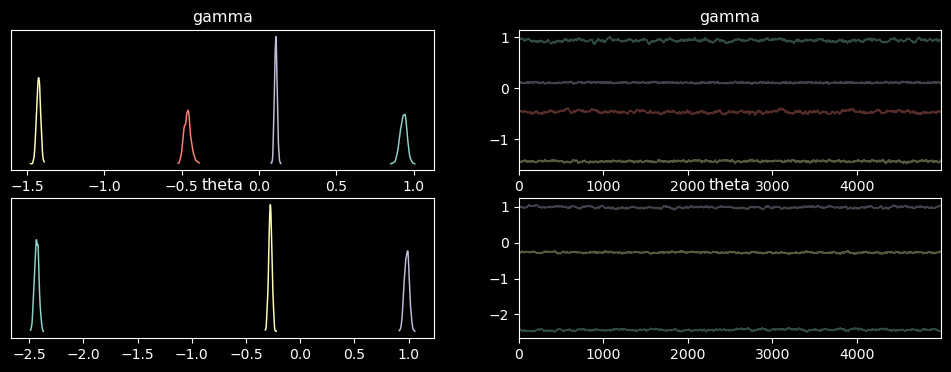

In [131]:
az.plot_trace(idata_net, var_names=["gamma", "theta"])

In [53]:
class Obs_Data(NamedTuple):
    x: Any
    Z: Any
    Y: Any
    df_edges: Any
    triu_obs: Any


obs_data = Obs_Data(x, Z, Y, df_edges, triu_obs)

print(obs_data.df_edges.shape, jnp.all(obs_data.df_edges == df_edges))


(124750, 3) True


In [112]:
### Metroplis-Within-Gibbs Kernel ###
 
# 1. Define the log posterior function

# outcome model log posterior (log density)
def logdensity_Y(position, cur_triu_star):
    return -potential_fn_gen_outcome(x, Z, cur_triu_star, Y)(position)

# network model log posterior (log density)
def logdensity_nets(position, cur_triu_star):
    return -potential_fn_gen_network(cur_triu_star, triu_obs, df_edges)(position)

#  Kernels (marginal)

mala_step_y = blackjax.mala.build_kernel()
mala_step_nets = blackjax.mala.build_kernel()

mala_init_y = blackjax.mala.init
mala_init_nets = blackjax.mala.init

# GWG kernel given observed data
def gwg_step(rng_key_, state_, theta_, gamma_, eta_, sig_y_, step_size):
    return GWG_kernel(rng_key_, state_, triu_obs, df_edges, theta_, gamma_,
                Y, x, Z, eta_, sig_y_, step_size)
    

In [113]:
gwg_step(key, final_carry[1], theta, gamma, eta, sig_y, 1.0)

(IPState(positions=Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), logdensity=Array(-97065.77, dtype=float32), logdensity_grad=Array([-3.146753 , -3.0533268, -3.283277 , ..., -3.6828635, -1.8605068,
        -2.3373919], dtype=float32), scores=Array([-1.5733765, -1.5266634, -1.6416385, ..., -1.8414317, -0.9302534,
        -1.1686959], dtype=float32)),
 IPInfo(acceptance_rate=Array(0.82953525, dtype=float32), is_accepted=Array(False, dtype=bool)))

In [121]:

def MWG_kernel(rng_key, states, step_sizes):
    key_y, key_nets, key_triu_star = random.split(rng_key, 3)

    # copy states 
    # state_y = state_y.copy()
    # state_nets = state_nets.copy()
    # state_triu_star = state_triu_star.copy()
    states = states.copy()

    # --- update for triu_star ---
    states["triu_star"], info_triu_star = gwg_step(rng_key_=key_triu_star,
                                                   state_=states["triu_star"],
                                                   theta_=states["nets"].position["theta"],
                                                    gamma_= states["nets"].position["gamma"],
                                                    eta_= states["Y"].position["eta"],
                                                    sig_y_= jnp.exp(states["Y"].position["sig_y"]),
                                                    step_size=step_sizes["triu_star"])

    # --- update for Y ---
    # conditional density (log posterior)
    def logdensity_fn_y(vals): return logdensity_Y(vals, states["triu_star"].positions)

    # run mala step
    states["Y"], info_y = mala_step_y(key_y, states["Y"], logdensity_fn_y, step_sizes["Y"])
    # states["Y"] contain current 'eta' and 'sig_y' values
    # e.g., state["Y"].position["eta"] and state["Y"].position["sig_y"]

    # --- update for network ---
    # conditional density (log posterior)
    def logdensity_fn_nets(vals): return logdensity_nets(vals, states["triu_star"].positions)

    # run mala step
    states["nets"], info_nets = mala_step_nets(key_nets, states["nets"], logdensity_fn_nets, step_sizes["nets"])
    # states["networks"] contain current 'gamma' and 'theta' values
    # e.g., state["networks"].position["gamma"] and state["networks"].position["theta"]



    infos = {"Y": info_y, "nets": info_nets, "triu_star": info_triu_star}

    return states, infos

In [137]:
init_triu_star = (triu_star * random.binomial(key, n=1, p=0.9, shape=(triu_dim,)) +
                   (1-triu_star) * random.binomial(key, n=1, p=0.1, shape=(triu_dim,)))

In [138]:
# triu_star_noisy = triu_obs
triu_star_noisy = init_triu_star
(f_init,_), grad_init = val_grad_fn(triu_star_noisy,
                                    triu_obs,
                                    df_edges,
                                    initial_position_net["theta"],
                                    initial_position_net["gamma"],
                                    Y, x, Z,
                                    initial_position_oc["eta"],
                                    jnp.exp(initial_position_oc["sig_y"]))

init_scores = (-(2*triu_star_noisy-1)*grad_init)/2

init_states = {
    "Y": mala_init_y(position=initial_position_oc,
                    logdensity_fn=lambda vals: logdensity_Y(vals, final_carry[1].positions)),
    "nets": mala_init_nets(position=initial_position_net,
                                logdensity_fn=lambda vals: logdensity_nets(vals, final_carry[1].positions)),
    "triu_star": IPState(triu_star_noisy, f_init, grad_init, init_scores)
}

init_step_sizes = {
    "Y": 1e-2,
    "nets": 1e-2,
    "triu_star": 1.0
}

In [139]:
%%time

class AdaptMWGState(NamedTuple):
    states: Any
    step_sizes: Any
    mean_acceptances: Any
    iteration: int

def mwg_loop(rng_key,
             kernel,
             init_states: dict,
             init_step_sizes: dict,
             num_samples: int,
             adapt_windows = {"Y": 20, "nets": 20, "triu_star": 10},
             target_acceptances = {"Y": 0.8, "nets": 0.8, "triu_star": 0.574},
             adaption_rates = {"Y": 0.1, "nets": 0.1, "triu_star": 0.05},
             num_warmup = 5000):
    
    def one_step(carry, key):
        adapt_state = carry
        
        # Run MWG step
        new_states, infos = kernel(key,
                                   adapt_state.states,
                                   adapt_state.step_sizes)
        
        # Update step sizes
        new_step_sizes = {} 
        # --- Y ---
        should_adapt_Y = ((adapt_state.iteration + 1) % adapt_windows["Y"] == 0) & (adapt_state.iteration <= num_warmup)
        new_step_sizes["Y"] = jnp.where(
            should_adapt_Y,
            adaptive_step_size_mala(adapt_state.step_sizes["Y"],
                                    infos["Y"].acceptance_rate,
                                    target_acceptances["Y"],
                                    adaption_rates["Y"]),
            adapt_state.step_sizes["Y"]
        )

        # --- networks ---
        should_adapt_nets = ((adapt_state.iteration + 1) % adapt_windows["nets"] == 0) & (adapt_state.iteration <= num_warmup)
        new_step_sizes["nets"] = jnp.where(
            should_adapt_nets,
            adaptive_step_size_mala(adapt_state.step_sizes["nets"],
                                    infos["nets"].acceptance_rate,
                                    target_acceptances["nets"],
                                    adaption_rates["nets"]),
            adapt_state.step_sizes["nets"]
        )

        # --- triu_star ---
        should_adapt_triu_star = ((adapt_state.iteration + 1) % adapt_windows["triu_star"] == 0) & (adapt_state.iteration <= num_warmup)
        new_step_sizes["triu_star"] = jnp.where(
            should_adapt_triu_star,
            adaptive_step_size(adapt_state.step_sizes["triu_star"],
                                infos["triu_star"].acceptance_rate,
                                target_acceptances["triu_star"],
                                adaption_rates["triu_star"]),
            adapt_state.step_sizes["triu_star"])
        # Update mean acceptance rates
        new_mean_accs = {}
        
        new_mean_accs["Y"] = adapt_state.mean_acceptances["Y"] + (
            infos["Y"].acceptance_rate - adapt_state.mean_acceptances["Y"]
        ) / (adapt_state.iteration + 1)

        new_mean_accs["nets"] = adapt_state.mean_acceptances["nets"] + (
            infos["nets"].acceptance_rate - adapt_state.mean_acceptances["nets"]
        ) / (adapt_state.iteration + 1)

        new_mean_accs["triu_star"] = adapt_state.mean_acceptances["triu_star"] + (
            infos["triu_star"].acceptance_rate - adapt_state.mean_acceptances["triu_star"]
        ) / (adapt_state.iteration + 1)


        new_adapt_state = AdaptMWGState(
            states=new_states,
            step_sizes=new_step_sizes,
            mean_acceptances=new_mean_accs,
            iteration=adapt_state.iteration + 1
        )

        return new_adapt_state, (new_states, infos, new_step_sizes)

    keys = random.split(rng_key, num_samples + num_warmup)
    init_adapt_state = AdaptMWGState(
        states=init_states,
        step_sizes=init_step_sizes,
        mean_acceptances={"Y": 0.0, "nets": 0.0, "triu_star": 0.0},
        iteration=0
    )

    _, (final_states, infos, final_step_sizes) = jax.lax.scan(one_step, init_adapt_state, keys)

    return final_states, infos, final_step_sizes

sample_key, warmup_key = random.split(warmup_key)

final_states, infos, final_step_sizes = mwg_loop(
    sample_key,
    MWG_kernel,
    init_states,
    init_step_sizes,
    num_samples=1000,
    target_acceptances={"Y": 0.8, "nets": 0.8, "triu_star": 0.574},
    adaption_rates={"Y": 0.05, "nets": 0.05, "triu_star": 0.01},
    num_warmup=3000
)



CPU times: total: 5min 3s
Wall time: 5min 2s


In [141]:
n_warmup = 3000
print("Y:", infos["Y"].acceptance_rate[n_warmup:].mean(), final_step_sizes["Y"][-1])
print("Nets:", infos["nets"].acceptance_rate[n_warmup:].mean(), final_step_sizes["nets"][-1])
print("Triu_star:", infos["triu_star"].acceptance_rate[n_warmup:].mean(), final_step_sizes["triu_star"][-1])

Y: 0.0 2.4787661e-05
Nets: 0.0 2.4787661e-05
Triu_star: 0.93122894 -0.19702108


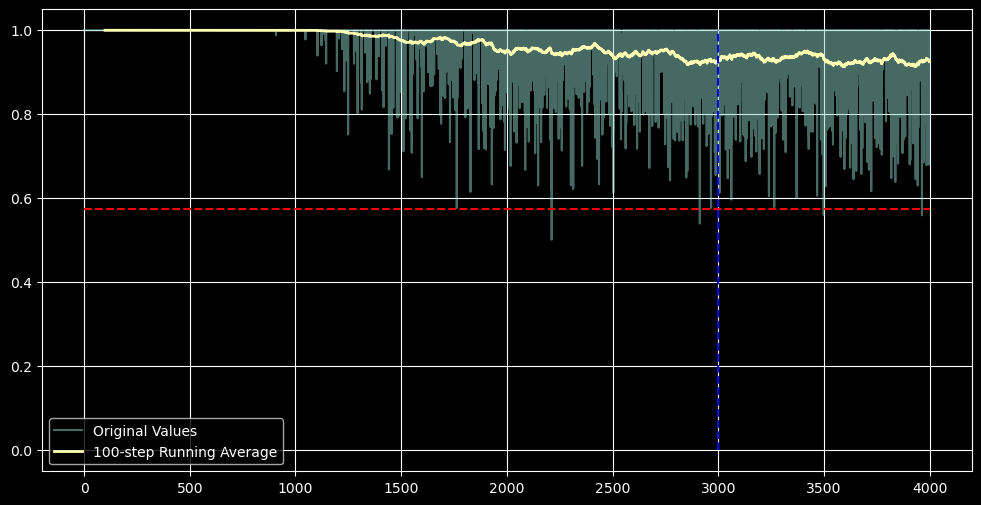

In [143]:
plot_running_average(infos["triu_star"].acceptance_rate, num_warmpup=n_warmup, target_rate=0.574)

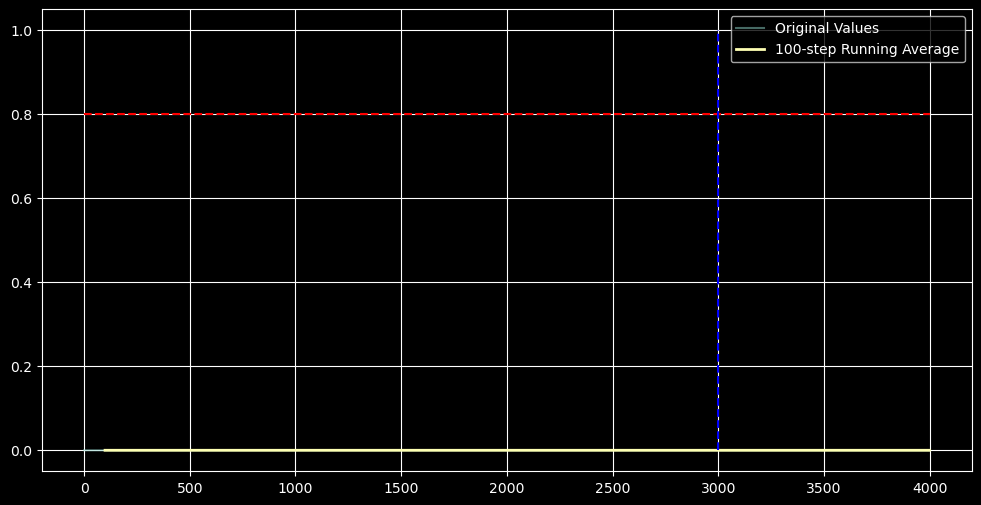

In [144]:
plot_running_average(infos["Y"].acceptance_rate, num_warmpup=n_warmup, target_rate=0.8)

In [132]:
print("true gamma: ", gamma, "\n",
      "true eta: ", eta, "\n",
      "true theta: ", theta)

post_y = {"eta" : final_states["Y"].position["eta"][n_warmup:,][None, ...],
            "sig_y" : jnp.exp(final_states["Y"].position["sig_y"][n_warmup:,][None, ...]),}

post_nets = {"gamma" : final_states["nets"].position["gamma"][n_warmup:,][None, ...],
            "theta" : final_states["nets"].position["theta"][n_warmup:,][None, ...],}

idata_y = az.from_dict(posterior=post_y)
idata_nets = az.from_dict(posterior=post_nets)

az.summary(idata_y)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


true gamma:  [ 0.84729785 -1.3862944   0.1        -0.5       ] 
 true eta:  [-1.    3.   -0.25  3.  ] 
 true theta:  [-2.5  -0.25  1.  ]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta[0],0.0,0.0,0.0,0.0,0.0,0.0,1000.0,1000.0,NaN
eta[1],0.0,0.0,0.0,0.0,0.0,0.0,1000.0,1000.0,NaN
eta[2],0.0,0.0,0.0,0.0,0.0,0.0,1000.0,1000.0,NaN
eta[3],0.0,0.0,0.0,0.0,0.0,0.0,1000.0,1000.0,NaN
sig_y,1.0,0.0,1.0,1.0,0.0,0.0,1000.0,1000.0,NaN


In [93]:
az.summary(idata_nets)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma[0],2.413,0.023,2.381,2.459,0.008,0.006,9.0,18.0,NaN
gamma[1],-3.935,0.041,-4.009,-3.870,0.035,0.034,1.0,23.0,NaN
gamma[2],-0.482,0.040,-0.540,-0.411,0.037,0.039,1.0,12.0,NaN
gamma[3],0.168,0.038,0.091,0.226,0.012,0.009,11.0,14.0,NaN
theta[0],-1.153,0.011,-1.173,-1.133,0.002,0.001,39.0,60.0,NaN
theta[1],0.097,0.008,0.083,0.113,0.001,0.001,58.0,139.0,NaN
theta[2],-0.165,0.016,-0.195,-0.134,0.003,0.002,24.0,44.0,NaN


In [145]:
exposures_post = vmap_compute_exposures(final_states["triu_star"].positions, Z)
print(exposures_post.shape)


(4000, 500)


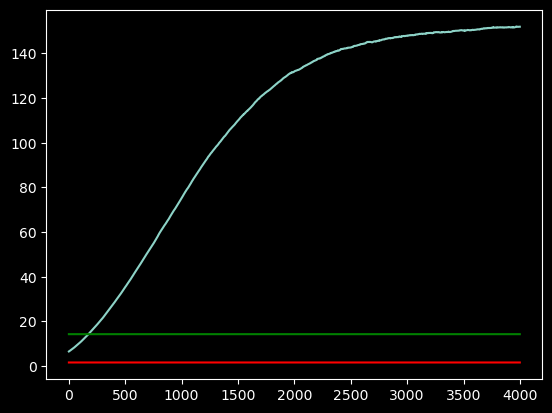

In [146]:

plt.plot(exposures_post.mean(axis=1))
plt.plot(jnp.ones(exposures_post.shape[0])*exposures.mean(), color='red')
plt.plot(jnp.ones(exposures_post.shape[0])*expos_obs.mean(), color='green')

In [ ]:
# https://blackjax-devs.github.io/blackjax/examples/howto_metropolis_within_gibbs.html
# TODO: think about initialisation startegies for latent variables (e.g. triu_star) in the model 
# TODO: probably should stick to GWG kernel and not DMALA for A* updates. 
# TODO: think about number of edges to update per iteration.

# TODO: update adaptive step size function to similar to the one in Stan algo
# TODO: think about initalization for all parameter
#        One option is to use optimzation to find the MAP estimate of the parameters
#       Here we maybe can use 'triu_obs' as init of 'triu_star' and then get MAP for each model.

# TODO: maybe perform number of MALA updates for each 'triu_star' update?


# TODO: Parallel code that run multiple chain of MWG in parallel
# TODO: Finally, wrap everything in seperate scripts and classes